In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [2]:
infosys = pd.read_csv("data/INFY.NS.csv", parse_dates=['Date'], dayfirst=True)
infosys=infosys.set_index("Date")
infosys.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,0.794921,0.796679,0.791015,0.796679,0.519068,204800
1996-01-02,0.794921,0.798828,0.793457,0.793457,0.516969,204800
1996-01-03,0.798828,0.798828,0.798828,0.798828,0.520468,102400
1996-01-04,0.791015,0.794921,0.791015,0.793554,0.517032,307200
1996-01-05,0.784179,0.784179,0.784179,0.784179,0.510924,51200


<Axes: xlabel='Date'>

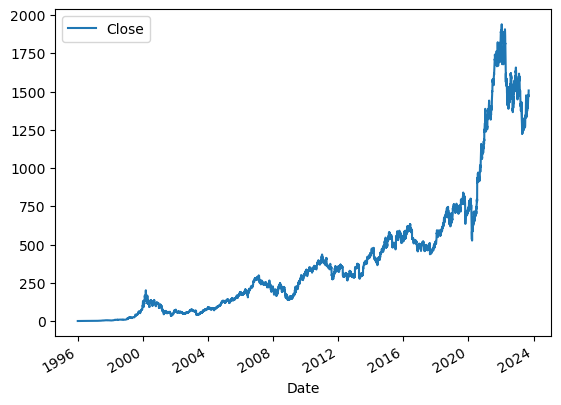

In [3]:
infosys.plot.line(y="Close", use_index=True)

In [4]:
infosys["Tomarrow"] = infosys["Close"].shift(-1)

In [5]:
infosys["Target"] = (infosys["Tomarrow"]>infosys["Close"]).astype(int)

In [6]:
infosys

,Open,High,Low,Close,Adj Close,Volume,Tomarrow,Target
Date,,,,,,,,
1996-01-01,0.794921,0.796679,0.791015,0.796679,0.519068,204800,0.793457,0
1996-01-02,0.794921,0.798828,0.793457,0.793457,0.516969,204800,0.798828,1
1996-01-03,0.798828,0.798828,0.798828,0.798828,0.520468,102400,0.793554,0
1996-01-04,0.791015,0.794921,0.791015,0.793554,0.517032,307200,0.784179,0
1996-01-05,0.784179,0.784179,0.784179,0.784179,0.510924,51200,0.789062,1
...,...,...,...,...,...,...,...,...
2023-09-08,1463.500000,1474.750000,1460.199951,1469.599976,1469.599976,3125838,1476.449951,1
2023-09-11,1469.599976,1478.050049,1464.500000,1476.449951,1476.449951,4182226,1501.099976,1
2023-09-12,1482.500000,1504.000000,1477.099976,1501.099976,1501.099976,6793161,1498.349976,0


In [7]:

nan_df = infosys.isna()

stacked = nan_df.stack()
nan_locations = stacked[stacked].reset_index()
nan_locations.columns = ['Row', 'Column', 'IsNaN']
print("Exact locations of NaN values:")
print(nan_locations)

Exact locations of NaN values:
         Row    Column  IsNaN
0 2023-09-14  Tomarrow   True


In [8]:
model=RandomForestClassifier(n_estimators=100,min_samples_split=100,random_state=1)

train=infosys.iloc[:-100]
test = infosys.iloc[-100:]

predictors = ["Close","Volume","Open","High","Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [9]:
preds = model.predict(test[predictors])

In [10]:
preds=pd.Series(preds,index=test.index)

In [11]:
precision_score(test["Target"], preds)

0.5517241379310345

In [12]:
combined = pd.concat([test["Target"],preds],axis=1)

<Axes: xlabel='Date'>

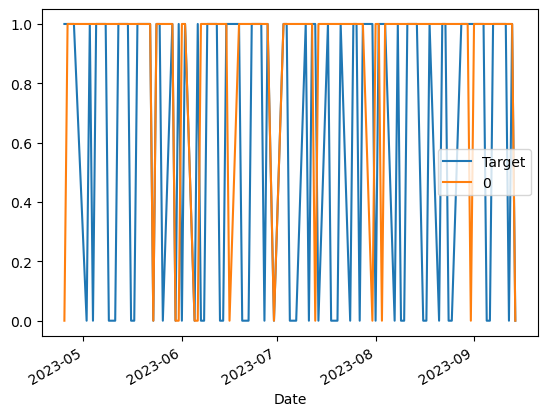

In [13]:
combined.plot()

In [14]:
def predict(train,test,predictors,model):
    model.fit(train[predictors],train["Target"])
    preds=model.predict(test[predictors])
    preds=preds=pd.Series(preds,index=test.index, name="Predictions")
    combined = pd.concat([test["Target"],preds],axis=1)
    return combined

In [15]:
def backtest(data,model,predictors,start=2500, step=250):
    all_predictions=[]
    
    for i in range(start,data.shape[0],step):
        train=data.iloc[0:i].copy()
        test=data.iloc[i:(i+step)].copy()
        predictions=predict(train,test,predictors,model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [16]:
predictions=backtest(infosys, model, predictors)

In [17]:
predictions["Predictions"].value_counts()

0    2564
1    1904
Name: Predictions, dtype: int64

In [18]:
precision_score(predictions["Target"],predictions["Predictions"])

0.5126050420168067

In [19]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.515667
0    0.484333
Name: Target, dtype: float64

In [20]:
horizons = [2,5,60,250,1000]
new_predictors=[]

for horizon in horizons:
    rolling_averages=infosys.rolling(horizon).mean()
    
    ratio_column =f"Close_Ratio_{horizon}"
    infosys[ratio_column]=infosys["Close"]/rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    infosys[trend_column]=infosys.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+=[ratio_column,trend_column]

In [21]:
infosys=infosys.dropna()

In [22]:
model=RandomForestClassifier(n_estimators=200,min_samples_split=50,random_state=1)

In [23]:
def predict(train,test,predictors,model):
    model.fit(train[predictors],train["Target"])
    preds=model.predict_proba(test[predictors])[:,1]
    preds[preds>=.52]=1
    preds[preds<.52]=0
    preds=preds=pd.Series(preds,index=test.index, name="Predictions")
    combined = pd.concat([test["Target"],preds],axis=1)
    return combined

In [24]:
predictions=backtest(infosys, model, new_predictors)

In [25]:
predictions["Predictions"].value_counts()

0.0    2238
1.0    1229
Name: Predictions, dtype: int64

In [26]:
precision_score(predictions["Target"],predictions["Predictions"])

0.5419039869812856